# Analyzing Last Interaction Velocity (LIV) Distribution

<div class="alert alert-info">

**Note:**

This notebook demonstrates how to calculate and visualize the last interaction velocity distribution of packets in a TARDIS simulation. You can also have a look at the `LIVPlotter` class in the tardis visualization module in order to see more features related to this.

</div>


In [1]:
import numpy as np
import pandas as pd
from astropy import units as u

from tardis.util.base import (
    atomic_number2element_symbol,
    element_symbol2atomic_number,
    int_to_roman,
    species_string_to_tuple,
)
import matplotlib.pyplot as plt

from tardis.visualization import plot_util as pu

/home/runner/work/tardis/tardis/tardis/__init__.py:23: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

ImportError: cannot import name 'parse_density_from_config' from partially initialized module 'tardis.io.model.parse_density_configuration' (most likely due to a circular import) (/home/runner/work/tardis/tardis/tardis/io/model/parse_density_configuration.py)

Every simulation run requires [atomic data](io/configuration/components/atomic/atomic_data.rst) and a [configuration file](io/configuration/index.rst). 

## Atomic Data

We recommend using the [kurucz_cd23_chianti_H_He.h5](https://github.com/tardis-sn/tardis-regression-data/raw/main/atom_data/kurucz_cd23_chianti_H_He.h5) dataset.

In [2]:
from tardis.io.atom_data import download_atom_data

# We download the atomic data needed to run the simulation
download_atom_data("kurucz_cd23_chianti_H_He")

Configuration File /home/runner/.astropy/config/tardis_internal_config.yml does not exist - creating new one from default


CRITICAL:root:
********************************************************************************

TARDIS will download different kinds of data (e.g. atomic) to its data directory /home/runner/Downloads/tardis-data

TARDIS DATA DIRECTORY not specified in /home/runner/.astropy/config/tardis_internal_config.yml:

ASSUMING DEFAULT DATA DIRECTORY /home/runner/Downloads/tardis-data
 YOU CAN CHANGE THIS AT ANY TIME IN /home/runner/.astropy/config/tardis_internal_config.yml 

******************************************************************************** 




You can also obtain a copy of the atomic data from the [tardis-regression-data](https://github.com/tardis-sn/tardis-regression-data/tree/main/atom_data) repository.

## Example Configuration File

The configuration file [tardis_example.yml](https://github.com/tardis-sn/tardis/tree/master/docs/tardis_example.yml) is used throughout this Quickstart.

In [3]:
!wget -q -nc https://raw.githubusercontent.com/tardis-sn/tardis/master/docs/tardis_example.yml

In [4]:
!cat tardis_example.yml

# Example YAML configuration for TARDIS
tardis_config_version: v1.0

supernova:
  luminosity_requested: 9.44 log_lsun
  time_explosion: 13 day

atom_data: kurucz_cd23_chianti_H_He.h5

model:
  structure:
    type: specific
    velocity:
      start: 1.1e4 km/s
      stop: 20000 km/s
      num: 20
    density:
      type: branch85_w7

  abundances:
    type: uniform
    O: 0.19
    Mg: 0.03
    Si: 0.52
    S: 0.19
    Ar: 0.04
    Ca: 0.03

plasma:
  disable_electron_scattering: no
  ionization: lte
  excitation: lte
  radiative_rates_type: dilute-blackbody
  line_interaction_type: macroatom

montecarlo:
  seed: 23111963
  no_of_packets: 4.0e+4
  iterations: 20
  nthreads: 1

  last_no_of_packets: 1.e+5
  no_of_virtual_packets: 10

  convergence_strategy:
    type: damped
    damping_constant: 1.0
    threshold: 0.05
    fraction: 0.8
    hold_iterations: 3
    t_inner:
      damping_constant: 0.5

spectrum:
  start: 500 angstrom
  stop: 20000 angstrom
  num: 10000


## Running the Simulation

To run the simulation, import the `run_tardis` function and create the `sim` object.

<div class="alert alert-info">

**Note:**

Get more information about the [progress bars](io/output/progress_bars.rst), [logging configuration](io/optional/tutorial_logging_configuration.ipynb), and [convergence plots](io/visualization/tutorial_convergence_plot.ipynb).

</div>

In [5]:
from tardis import run_tardis

# Run the TARDIS simulation
simulation = run_tardis("tardis_example.yml", log_level="ERROR")

BokehModel(combine_events=True, render_bundle={'docs_json': {'177cf0ed-f54c-44ae-be22-def958a5e3fb': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

## HDF

TARDIS can save simulation data to HDF files for later analysis. The code below shows how to load a simulation from an HDF file. This is useful when you want to analyze simulation results without re-running the simulation.

In [6]:
# import astropy.units as u
# import pandas as pd

# hdf_fpath = "add_file_path_here"
# with pd.HDFStore(hdf_fpath, "r") as hdf:
#     sim = u.Quantity(hdf["/simulation"])

## Extracting and Processing Packet Interaction Data


### Core simulation parameters

In [7]:
time_explosion = simulation.plasma.time_explosion
velocity = simulation.simulation_state.velocity
transport_state = simulation.transport.transport_state

### Packet DataFrame Creation

Creating a DataFrame to store packet properties including frequencies, wavelengths, energies and interaction details.

In [8]:
# Extract frequencies of emitted packets and convert to Hz units
packet_nus = u.Quantity(
    transport_state.packet_collection.output_nus[
        transport_state.emitted_packet_mask
    ],
    u.Hz,
)

packets_df = pd.DataFrame(
    {
        # Frequency of packets
        "nus": packet_nus,
        # Convert frequencies to wavelengths in Angstroms
        "lambdas": packet_nus.to("angstrom", u.spectral()),

        "energies": transport_state.packet_collection.output_energies[
            transport_state.emitted_packet_mask
        ],
        "last_interaction_type": transport_state.last_interaction_type[
            transport_state.emitted_packet_mask
        ],
        # ID of spectral line involved in last interaction (input transition)
        "last_line_interaction_in_id": transport_state.last_line_interaction_in_id[
            transport_state.emitted_packet_mask
        ],
        # ID of spectral line involved in last interaction (output transition)
        "last_line_interaction_out_id": transport_state.last_line_interaction_out_id[
            transport_state.emitted_packet_mask
        ],
        "last_line_interaction_in_nu": transport_state.last_interaction_in_nu[
            transport_state.emitted_packet_mask
        ],
        # Radius at which last interaction occurred
        "last_interaction_in_r": transport_state.last_interaction_in_r[
            transport_state.emitted_packet_mask
        ],
    }
)


### Species Identification
Processing atomic numbers and species IDs for packets that had line interactions.

In [9]:
line_mask = (packets_df["last_interaction_type"] > -1) & (
    packets_df["last_line_interaction_in_id"] > -1
)
packets_df_line_interaction = packets_df.loc[line_mask].copy()

# Add columns for atomic number and species ID of the last interaction
lines_df = simulation.plasma.atomic_data.lines.reset_index().set_index(
    "line_id"
)
# Add column for atomic number of last interaction to enable analysis of
# which elements are involved in packet interactions.
packets_df_line_interaction["last_line_interaction_atom"] = (
    lines_df["atomic_number"]
    .iloc[packets_df_line_interaction["last_line_interaction_out_id"]]
    .to_numpy()
)

### Species List Generation 
Converting numerical species IDs to element symbols and organizing ions.

In [10]:
# Add column for species ID of last interaction to track both element and ionization state.
# Species ID = atomic_number * 100 + ion_number creates a unique identifier
# for each ion of each element (e.g. 1400 for neutral Si, 1401 for Si II etc.)
packets_df_line_interaction["last_line_interaction_species"] = (
    lines_df["atomic_number"]
    .iloc[packets_df_line_interaction["last_line_interaction_out_id"]]
    .to_numpy()
    * 100
    + lines_df["ion_number"]
    .iloc[packets_df_line_interaction["last_line_interaction_out_id"]]
    .to_numpy()
)

# Get unique species IDs from the packets that had line interactions
species_in_model = np.unique(
    packets_df_line_interaction["last_line_interaction_species"].values
)

# Convert species IDs to element symbols by dividing by 100 to get atomic number
# and get the corresponding element symbol
species_list = [
    f"{atomic_number2element_symbol(species // 100)}"
    for species in species_in_model
]


In [11]:
species_mapped = {}
species_flat_list = []
keep_colour = []

# go through each of the requested species. Check whether it is
# an element or ion (ions have spaces). If it is an element,
# add all possible ions to the ions list. Otherwise just add
# the requested ion
for species in species_list:
    if " " in species:
        species_id = (
            species_string_to_tuple(species)[0] * 100
            + species_string_to_tuple(species)[1]
        )
        species_flat_list.append([species_id])
        species_mapped[species_id] = [species_id]
    else:
        atomic_number = element_symbol2atomic_number(species)
        species_ids = [
            atomic_number * 100 + ion_number
            for ion_number in np.arange(atomic_number)
        ]
        species_flat_list.append(species_ids)
        species_mapped[atomic_number * 100] = species_ids
        # add the atomic number to a list so you know that this element should
        # have all species in the same colour, i.e. it was requested like
        # species_list = [Si]
        keep_colour.append(atomic_number)
species_flat_list = [
    species_id for temp_list in species_flat_list for species_id in temp_list
]

In [12]:
msk = np.isin(species_flat_list, species_in_model)
species = np.array(species_flat_list)[msk]

species_name = []
for species_key, species_ids in species_mapped.items():
    if any(species2 in species for species2 in species_ids):
        if species_key % 100 == 0:
            label = atomic_number2element_symbol(species_key // 100)
        else:
            atomic_number = species_key // 100
            ion_number = species_key % 100
            ion_numeral = int_to_roman(ion_number + 1)
            label = (
                f"{atomic_number2element_symbol(atomic_number)} {ion_numeral}"
            )
        species_name.append(label)


### Color Mapping
Setting up color schemes for visualizing different atomic species.

In [13]:
# Get a colormap with distinct colors for each species
cmap = plt.get_cmap("jet", len(species_name))

# Initialize list to store colors for each species
_color_list = []
species_keys = list(species_mapped.keys())
num_species = len(species_keys)

# Assign colors to each species that appears in the simulation
for species_counter, species_key in enumerate(species_keys):
    # Check if any of the ions of this species are present in the simulation
    if any(species2 in species for species2 in species_mapped[species_key]):
        # Get color from colormap and normalize by number of species
        color = cmap(species_counter / num_species)
        _color_list.append(color)


### Data Grouping and Binning
Grouping packets by species and preparing binned data for visualization.

In [14]:
packet_nu_line_range_mask = np.ones(
    packets_df_line_interaction.shape[0],
    dtype=bool,
)

# Group packets by their last line interaction species 
groups = packets_df_line_interaction.loc[packet_nu_line_range_mask].groupby(
    by="last_line_interaction_species"
)

plot_colors = []
plot_data = []
species_not_wvl_range = []
species_counter = 0

# Iterate through each species to collect velocity data
for species_groups in species_mapped.values():
    full_v_last = []
    for specie in species_groups:
        if specie in species:
            # Skip if species has no interactions
            if specie not in groups.groups:
                atomic_number = specie // 100
                ion_number = specie % 100
                ion_numeral = int_to_roman(ion_number + 1)
                label = f"{atomic_number2element_symbol(atomic_number)} {ion_numeral}"
                species_not_wvl_range.append(label)
                continue

            # Calculate velocities from radii using v = r/t
            g_df = groups.get_group(specie)
            r_last_interaction = g_df["last_interaction_in_r"].values * u.cm
            v_last_interaction = (r_last_interaction / time_explosion).to(
                "km/s"
            )
            full_v_last.extend(v_last_interaction)

    if full_v_last:
        plot_data.append(full_v_last)
        plot_colors.append(_color_list[species_counter])
        species_counter += 1

# Use velocity grid as bin edges for histogram
bin_edges = velocity.to("km/s")

## Visualizing Last Interaction Velocity Distribution



The plots below show the velocity distribution of the last interaction points for different atomic species in the TARDIS simulation. This helps understand where in the ejecta different elements contribute to the observed spectrum.

Each line represents a different element/ion, with:

- The x-axis showing the ***velocity*** in ($\text{km} \, \text{s}^{-1}$) where the last interaction occurred
- The y-axis showing the ***number of packets*** that had their last interaction at that velocity

### Matplotlib


NameError: name 'pu' is not defined

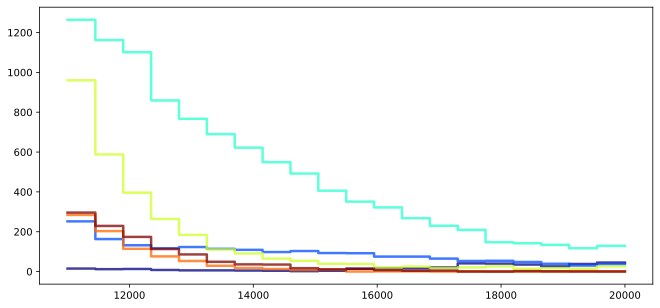

In [15]:
ax = plt.figure(figsize=(11, 5)).add_subplot(111)

for data, color, name in zip(plot_data, plot_colors, species_name):
    # Generate step plot data from histogram data
    hist, _ = np.histogram(data, bins=bin_edges)
    step_x = np.repeat(bin_edges, 2)[1:-1]
    step_y = np.repeat(hist, 2)
    ax.plot(
        step_x,
        step_y,
        label=name,
        color=color,
        linewidth=2.5,
        drawstyle="steps-post",
        alpha=0.75,
    )


# set labels, and legend
xlabel = pu.axis_label_in_latex(
    "Last Interaction Velocity", u.Unit("km/s"), only_text=True
)
ax.ticklabel_format(axis="y", scilimits=(0, 0))
ax.tick_params("both", labelsize=15)
ax.set_xlabel(xlabel, fontsize=14)
ax.set_ylabel(r"$\text{Packet Count}$", fontsize=15)
ax.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0), loc="upper left")
ax.figure.tight_layout()

### Plotly


In [16]:
import plotly.graph_objects as go

# Create plotly figure
fig = go.Figure()

# Loop through each species data and plot histogram
for data, color, name in zip(plot_data, plot_colors, species_name):
    # Generate step plot data from histogram data
    hist, _ = np.histogram(data, bins=bin_edges)
    step_x = np.repeat(bin_edges, 2)[1:-1]
    step_y = np.repeat(hist, 2)

    # Add trace for each species with step-like line plot
    fig.add_trace(
        go.Scatter(
            x=step_x,
            y=step_y,
            mode="lines",
            line=dict(
                color=pu.to_rgb255_string(color),
                width=2.5,
                shape="hv",  # Horizontal-vertical steps
            ),
            name=name,
            opacity=0.75,
        )
    )

xlabel = pu.axis_label_in_latex(
    "Last Interaction Velocity", u.Unit("km/s"), only_text=True
)
fig.update_layout(
    height=600,
    xaxis_title=xlabel,
    font=dict(size=15),
    yaxis={"title": r"$\text{Packet Count}$", "exponentformat": "e", "tickformat":".1e"},
    xaxis=dict(exponentformat="none"),
)


NameError: name 'pu' is not defined